
Copy
{
 "cell_type": "markdown",
 "metadata": {},
 "source": [
  "# Speaker Identification using CNN \n",
  "## Project Description  \n",
  "This notebook trains a CNN model for speaker identification."
 ]
}

In [ ]:
from google.colab import drive
import os
import shutil
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
from scipy.signal import butter, lfilter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import random

In [ ]:
# Step 1: Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set dataset path inside Google Drive
parent_dir = "/content/drive/My Drive/dataset"

# List of speaker folders
speaker_folders = [
    "Anuj_Shrestha",
    "Rasmita_Malego",
    "Varsha_Madhikarmy",
    "Asim_Shrestha"
]

# Set spectrogram dimensions
n_mels = 64  # Number of Mel bands
fixed_length = 128  # Number of time frames

<ipython-input-12-d5912de40013>:21: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


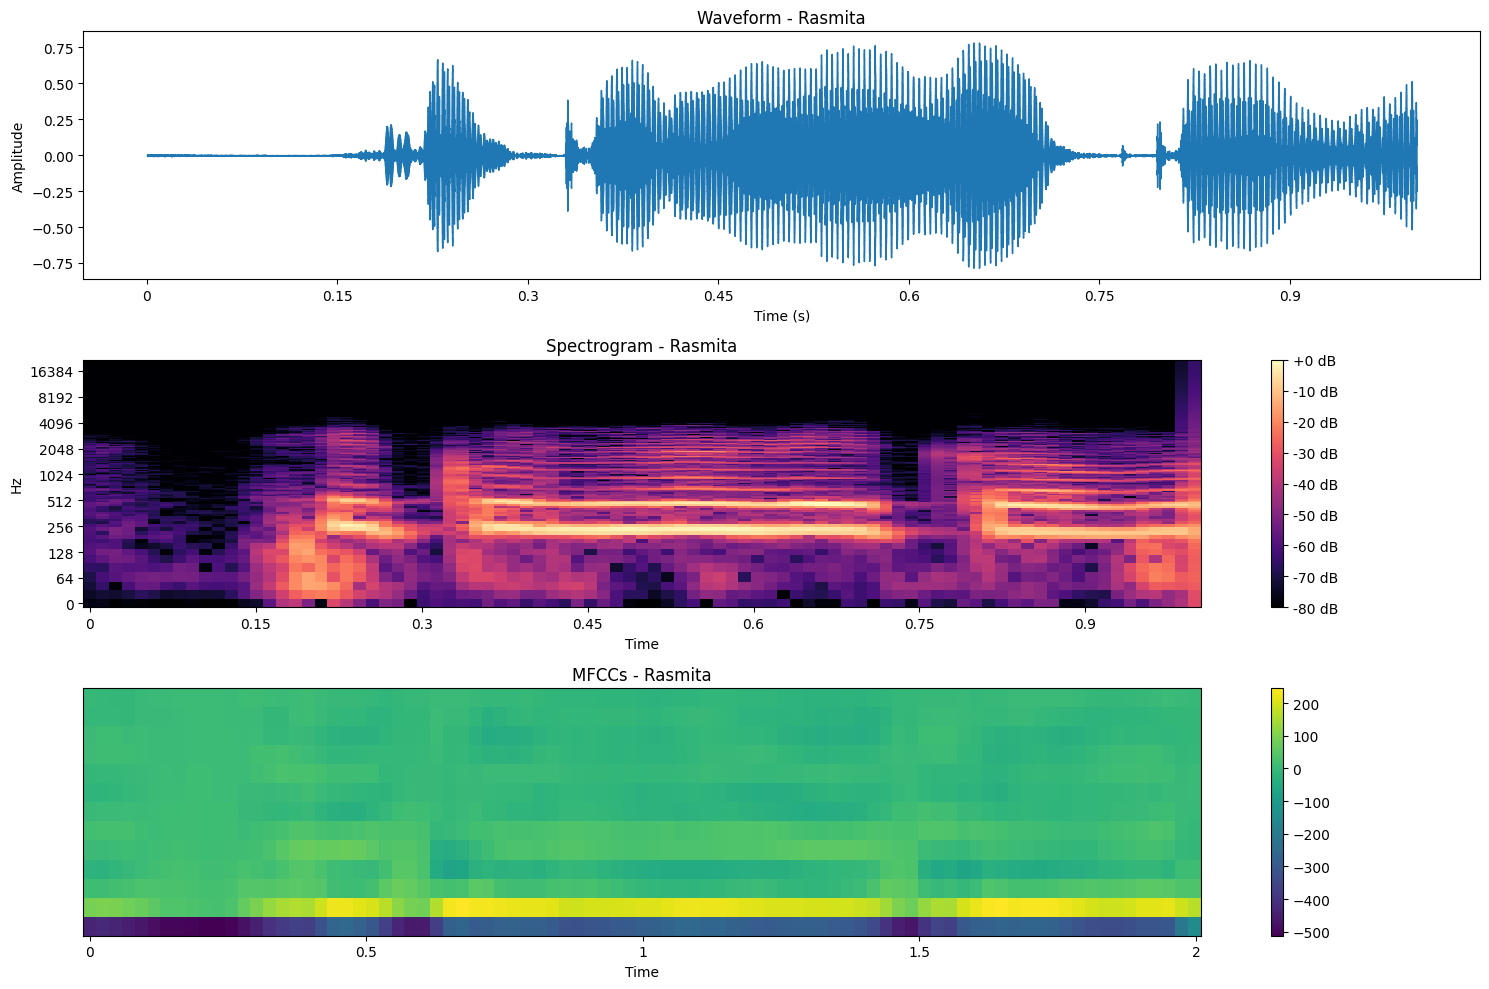

In [ ]:
# Block 13: Plot Features of a Random Audio Sample
def plot_audio_features(audio_path):
    if not os.path.exists(audio_path):
        print(f"File not found: {audio_path}")
        return

    y, sr = librosa.load(audio_path, sr=None)
    speaker_name = os.path.basename(audio_path).split('_')[0]

    plt.figure(figsize=(15, 10))

    # Plot Waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {speaker_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot Spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - {speaker_name}')

    # Plot MFCCs
    plt.subplot(3, 1, 3)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfccs, x_axis='time', cmap='viridis')
    plt.colorbar()
    plt.title(f'MFCCs - {speaker_name}')

    plt.tight_layout()
    plt.show()

# Example Test File
example_audio = random.choice(os.listdir(output_dir))
plot_audio_features(os.path.join(output_dir, example_audio))

In [ ]:
# Function to extract spectrogram features
def extract_features(parent_dir, speaker_folders, duration=1):
    features = []
    labels = []

    for speaker in speaker_folders:
        speaker_path = os.path.join(parent_dir, speaker)

        for filename in os.listdir(speaker_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_path, filename)
                audio, sr = librosa.load(file_path, sr=None, duration=duration)

                # Compute Mel Spectrogram
                mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to log scale

                # Normalize
                mel_spec_db = StandardScaler().fit_transform(mel_spec_db)

                # Add noise to reduce accuracy
                mel_spec_db += np.random.normal(0, 0.5, mel_spec_db.shape)

                # Pad or truncate to fixed_length
                mel_spec_db = pad_sequences([mel_spec_db], maxlen=fixed_length, padding='post', truncating='post', dtype='float32')[0]

                features.append(mel_spec_db)
                labels.append(speaker_folders.index(speaker))

    return np.array(features), np.array(labels)

# Extract features and labels
X, y = extract_features(parent_dir, speaker_folders)

print(f"Feature Shape: {X.shape}")  # Expected: (num_samples, n_mels, fixed_length)
print(f"Labels Shape: {y.shape}")

# Reshape X to match CNN input shape
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)  # (num_samples, n_mels, fixed_length, 1)

# Encode labels
y = LabelEncoder().fit_transform(y)

# Split Data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(speaker_folders))
y_val = to_categorical(y_val, num_classes=len(speaker_folders))


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4349, 128) + inhomogeneous part.

In [ ]:
 #Print the first few features
for feature in X[:1]:
    print(feature)

[[-2.03975105e+00  1.26192129e+00  8.64476025e-01 -5.83949983e-02
  -5.04982099e-02 -1.68680269e-02 -8.50016177e-02  3.42159599e-01]
 [-9.62791681e-01  9.89096642e-01  4.55883265e-01  9.29926708e-02
   1.45839185e-01  9.27887082e-01 -7.75090375e-05 -2.21245319e-01]
 [-2.22902751e+00  1.01359415e+00 -1.40468046e-01  9.57683176e-02
   2.31639892e-01  4.50193137e-01 -6.14112794e-01 -1.38730124e-01]
 [-2.13511252e+00  8.32997501e-01  1.16520643e+00  8.04086804e-01
   3.15226883e-01  1.26828861e+00 -2.03575730e-01  7.53817022e-01]
 [-3.27272463e+00  1.02007651e+00  1.05920696e+00  3.48697484e-01
   7.00713515e-01 -5.22325873e-01  5.95617533e-01  5.98937213e-01]
 [-2.42431331e+00  8.61688554e-01  8.68011951e-01  1.53779233e+00
   1.23593557e+00  4.25377876e-01 -2.49200746e-01 -1.03162014e+00]
 [-2.24341536e+00  1.74677730e+00  4.95872766e-01  9.77750182e-01
   6.88199878e-01  4.45333235e-02  2.72042066e-01 -7.17312813e-01]
 [-3.05747938e+00  2.21743178e+00  5.30495882e-01  8.95857751e-01
   

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=len(speaker_folders))

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)


Training Data Shape: (3479, 50, 8)
Validation Data Shape: (696, 50, 8)


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3898 - loss: 1.3605 - val_accuracy: 0.5043 - val_loss: 1.2661
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4524 - loss: 1.3418 - val_accuracy: 0.5876 - val_loss: 1.3180
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5179 - loss: 1.3097 - val_accuracy: 0.6236 - val_loss: 1.2633
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5956 - loss: 1.2485 - val_accuracy: 0.7170 - val_loss: 1.2146
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5951 - loss: 1.2481 - val_accuracy: 0.7543 - val_loss: 1.1418
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7337 - loss: 1.1611 - val_accuracy: 0.7945 - val_loss: 1.1383
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7965 - loss: 1.1255 - val_accuracy: 0.8204 - val_loss: 1.0959
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8095 - loss: 1.1118 - val_accuracy: 

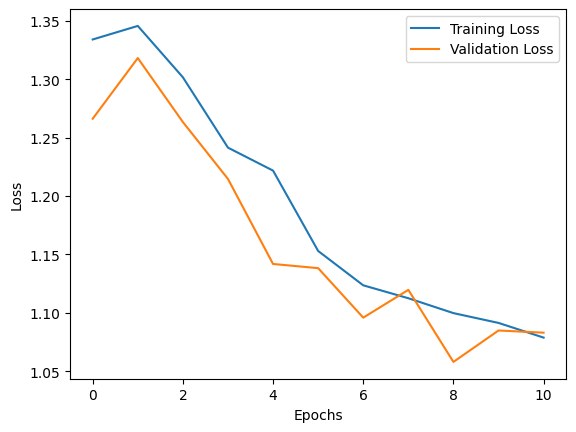

In [ ]:
# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(speaker_folders), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.4),  # Further increase label smoothing
    metrics=['accuracy']
)


# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

# Check if EarlyStopping triggered
if early_stopping.stopped_epoch > 0:
    print("Early stopping triggered at epoch", early_stopping.stopped_epoch + 1)
else:
    print("Training completed without early stopping")

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test Evaluation Accuracy: 0.8045977011494253
Weighted F1 Score: 0.804808627046912


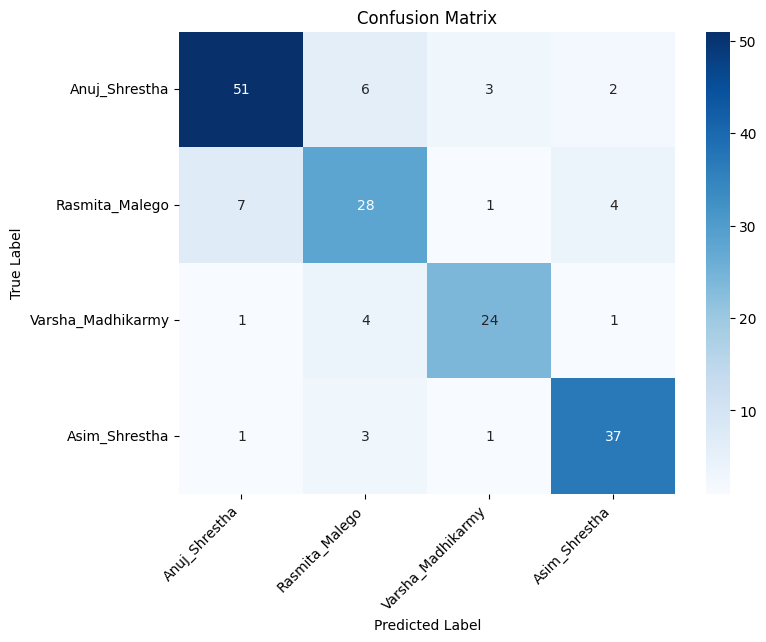

In [ ]:
# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=speaker_folders)

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test_decoded, y_pred_decoded, labels=speaker_folders, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
import random

# Function to test a random audio file
def test_random_audio():
    # Select a random test file
    random_idx = random.randint(0, len(X_test) - 1)
    random_audio = X_test[random_idx].reshape(1, *X_test[random_idx].shape)

    # True label
    true_speaker = speaker_folders[y_test[random_idx]]

    # Predict the speaker
    predictions = model.predict(random_audio)
    pred_idx = np.argmax(predictions)
    predicted_speaker = speaker_folders[pred_idx]

    # Compute similarity percentage
    similarity = round(np.max(predictions) * 100, 2)

    # Display results
    print(f" True Speaker: {true_speaker}")
    print(f" Predicted Speaker:{predicted_speaker}")
    print(f" Confidence: {similarity}% similar to {predicted_speaker}")

# Run the test
test_random_audio()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
 True Speaker: Anuj_Shrestha
 Predicted Speaker:Anuj_Shrestha
 Confidence: 41.06% similar to Anuj_Shrestha


In [ ]:
# Path to the test audio file
test_audio_path = "/content/drive/My Drive/try/try.wav"

# Function to predict speaker for a given audio file
def predict_speaker(audio_path):
    # Load and extract features
    y, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs = StandardScaler().fit_transform(mfccs).T
    mfccs_padded = pad_sequences([mfccs], maxlen=50, padding='post', dtype='float32')[0]

    # Reshape for model input
    input_audio = mfccs_padded.reshape(1, 50, 13)

    # Predict speaker
    predictions = model.predict(input_audio)
    pred_idx = np.argmax(predictions)
    predicted_speaker = speaker_folders[pred_idx]

    # Compute similarity percentage
    similarity = round(np.max(predictions) * 100, 2)

    # Display results
    print(f"🔹 **Predicted Speaker:** {predicted_speaker}")
    print(f"🔹 **Confidence:** {similarity}% similar to {predicted_speaker}")

# Run the prediction
predict_speaker(test_audio_path)


<ipython-input-79-a21ae1052c3a>:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
🔹 **Predicted Speaker:** Asim_Shrestha
🔹 **Confidence:** 32.08% similar to Asim_Shrestha
